# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [2]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import graphviz 
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA




# import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)



Using device: cpu


In [3]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [4]:
def calculate_averages_and_dispersion(data, data_percentage):
    df = data
    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

## Pivoting Frequency values to columns

In [5]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as and input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    # 1s window_size 100/27s = 3.7% of the data is used for each window
    df_window = calculate_averages_and_dispersion(df, data_percentage) 

    # Add a unique identifier column to avoid duplicate entries in the index
    df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

    # Pivot the DataFrame to wide format
    df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

    # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
    # df_pivot.columns = [' '.join(map(str, col)) for col in df_pivot.columns]
    df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]


    # Drop columns with all NaN values
    df_pivot = df_pivot.dropna(axis=1, how='all')

    # Reset index to make 'Sample' and 'unique_id' columns again
    df_pivot = df_pivot.reset_index()

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    # Remove 'unique_id' column
    df_pivot = df_pivot.drop(columns=['unique_id'])

    return df_pivot

In [6]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test/'
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test'

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df.head()

,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,-7.080942,-0.854611,A1
1,100.0,67.024785,0.244141,A1
2,100.0,124.893178,-1.098776,A1
3,100.0,91.075571,0.000000,A1
4,100.0,48.956174,0.122094,A1


## Balance Dataset

C:\Users\Danim\AppData\Local\Temp\ipykernel_39176\1209927551.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


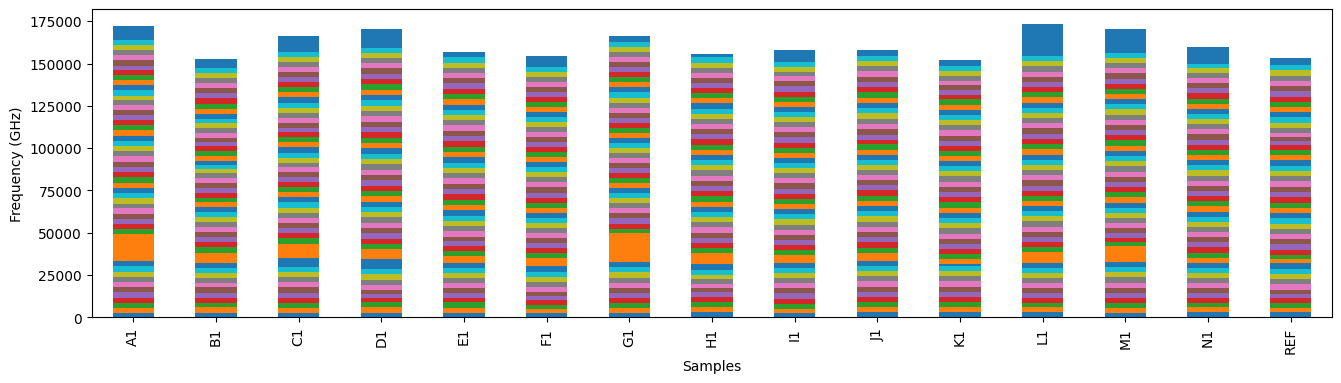

Mode value: 3033


C:\Users\Danim\AppData\Local\Temp\ipykernel_39176\1209927551.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


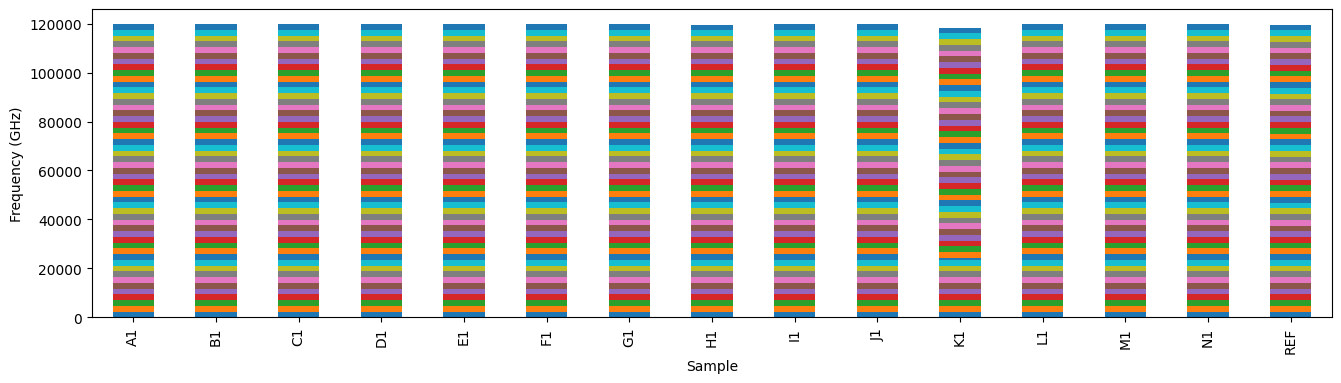

In [7]:
# Number of samples per frequency and Sample
bx = df.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_xlabel('Samples')
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
#no legend
bx.get_legend().remove()
plt.show()

# Balance the data by taking the mode of samples per frequency
mode = df.groupby(['Sample', 'Frequency (GHz)']).size().mode()[0]
print(f'Mode value: {mode}')
mode = 2350

# Function to reduce samples to the mode value
def reduce_to_mode(df, sample, frequency, mode):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mode, sample down to the mode
    if len(freq_df) > mode:
        return freq_df.sample(n=mode, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mode(df, sample, frequency, mode))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)

bx = df_balanced.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
# legend small
bx.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#remove legend
bx.get_legend().remove()
plt.show()

## Sample a test set

In [8]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.2
# train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 
train_set, test_set = train_test_split(df_balanced, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set

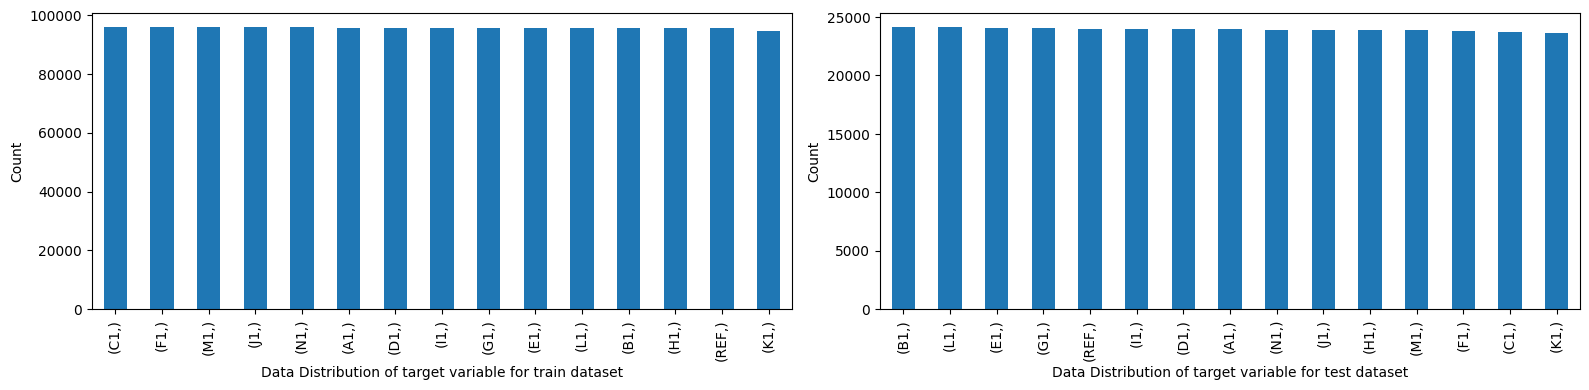

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [10]:
train_ex = train_set.copy()

In [11]:
train_ex.info()
# train_ex.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1436488 entries, 1723695 to 172769
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Frequency (GHz)  1436488 non-null  float64
 1   LG (mV)          1436488 non-null  float64
 2   HG (mV)          1436488 non-null  float64
 3   Sample           1436488 non-null  object 
dtypes: float64(3), object(1)
memory usage: 54.8+ MB


In [12]:
train_ex['Sample'].nunique()
train_ex['Frequency (GHz)'].value_counts().sort_index().index

Index([100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0,
       200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0,
       300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0,
       400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0,
       500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0,
       600.0],
      dtype='float64', name='Frequency (GHz)')

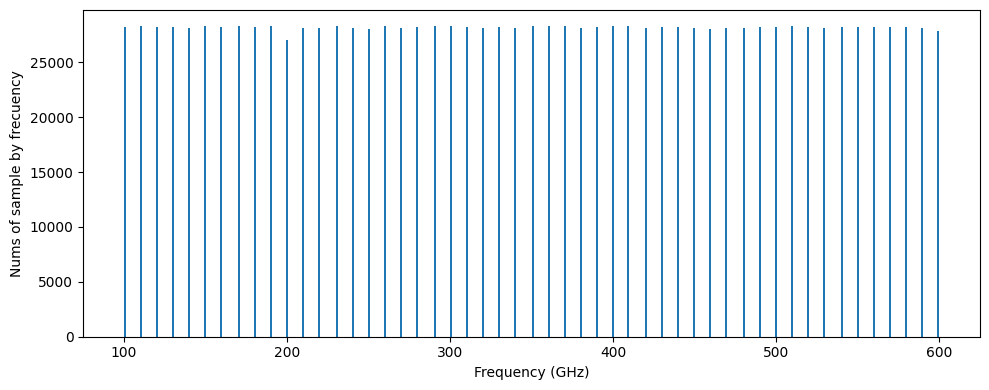

In [13]:

ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
# ax = test_set['Frequency (GHz)'].plot.hist(ax=ax, bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [75]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
data_percentage = (100/(27*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(27*(test_percentage)))*time_window_s
print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage = data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage = data_percentage_test)
# train_set_test.head()
# test_set_test.head()

# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

#Save the processed data to a CSV file

output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)



Data percentage: 0.462962962962963%
Data percentage test: 1.851851851851852%


# Prepare Training Data
## Split the data into X and y


In [320]:
def preprocess_data(df, labels, freqs, eliminate_std_dev=False):
    # Reduce number of different samples for testing
    X_ = df[df['Sample'].isin(labels)]

    y_ = X_['Sample']

    X_ = X_.drop(columns=['Sample'])

    if freqs:
        # Subset of specific frequencies to use as input features
        columns = [f'{freq}.0 HG (mV) mean' for freq in freqs] + \
                    [f'{freq}.0 LG (mV) mean' for freq in freqs] + \
                    [f'{freq}.0 HG (mV) std deviation' for freq in freqs] + \
                    [f'{freq}.0 LG (mV) std deviation' for freq in freqs]

        # Filter columns that exist in X_
        existing_columns = [col for col in columns if col in X_.columns]

        X_ = X_[existing_columns]

    if eliminate_std_dev:
        # Eliminate std dev columns
        X_ = X_.iloc[:, ::2]

    return X_, y_


In [322]:
# Subset of specific Samples to use in the training
labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']
# labels = ['E1', 'H1']

# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used
freqs = [320,380]
# freqs = []
#


X_train, y_train = preprocess_data(train_set_test, labels, freqs, eliminate_std_dev=False)
X_test, y_test = preprocess_data(test_set_test, labels, freqs, eliminate_std_dev=False)

# Encode the target variable if it's categorical
if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

if y_test.dtype == 'object':
    y_test = le.transform(y_test)


# le is the fitted LabelEncoder - Saving Encoder
joblib.dump(le, 'label_encoder.pkl')

X_train.head()



,320.0 HG (mV) mean,380.0 HG (mV) mean,320.0 LG (mV) mean,380.0 LG (mV) mean,320.0 HG (mV) std deviation,380.0 HG (mV) std deviation,320.0 LG (mV) std deviation,380.0 LG (mV) std deviation
0,-0.152603,310.951062,1.709193,0.549384,0.529157,12.639205,0.996109,0.741180
1,0.061029,308.173622,1.190331,0.213649,0.769373,7.145814,0.686753,1.379308
2,0.396776,301.901486,0.915639,0.259431,1.047664,6.840648,0.763817,0.653999
3,-0.320449,305.182543,1.327677,-0.076303,0.693484,14.113951,0.786986,1.017130
4,-0.152600,310.355898,1.281895,0.473080,0.379121,14.243058,0.312963,1.310742


### Principal Component Analysis

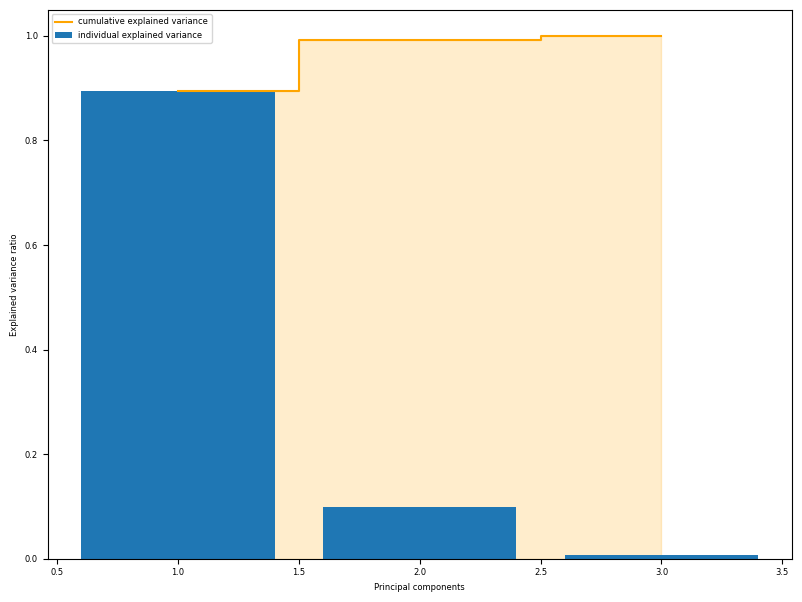

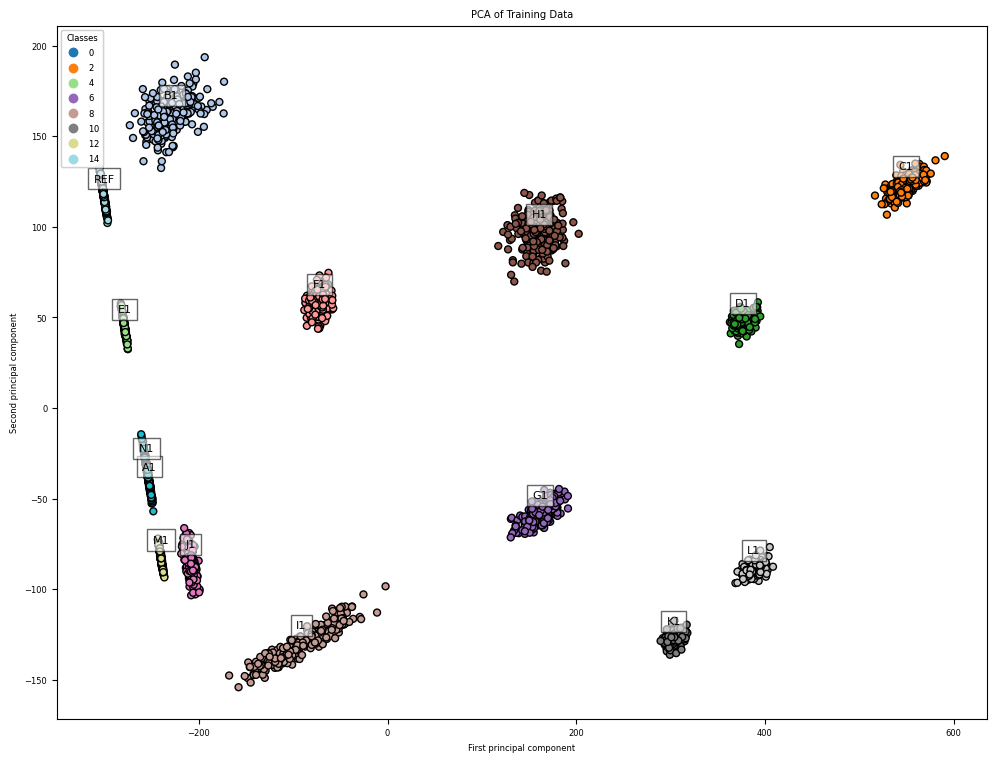

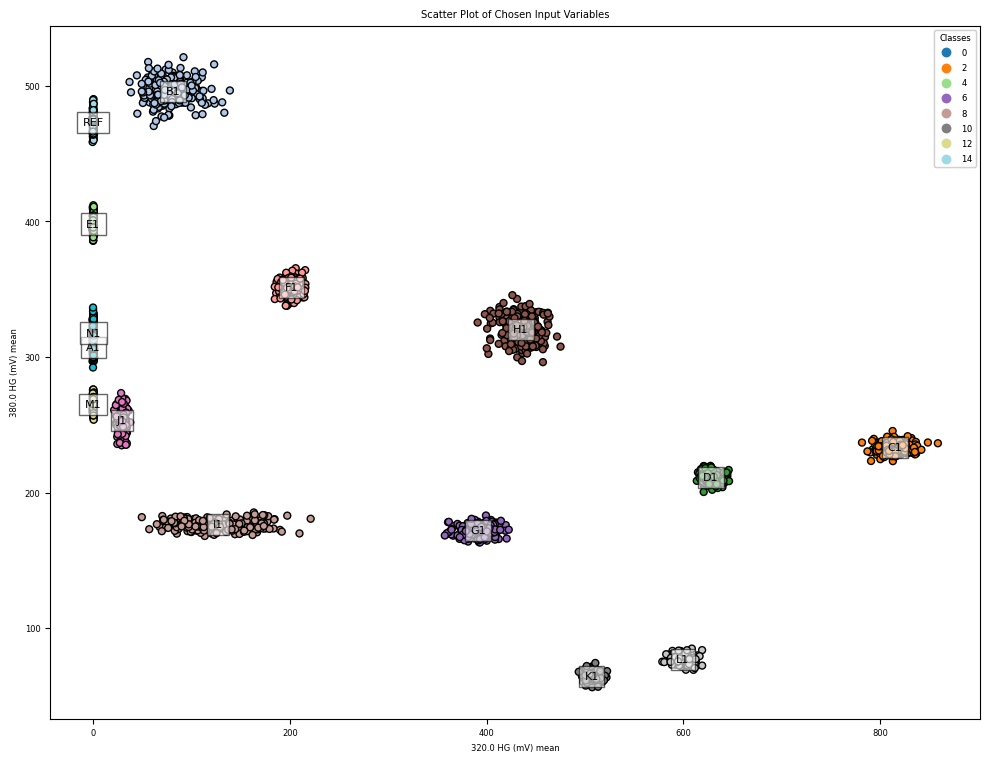

In [324]:
# Apply PCA
n_components = 3
pca = PCA(n_components)  # Reduce to 2 components for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_pca = y_train

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.step(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance', color='orange')
plt.fill_between(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), step='mid', alpha=0.2, color='orange')
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_, alpha=1.0, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### VISUALIZATION ###
# Plot the PCA components (first two components for visualization)
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_pca, cmap = 'tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 10
for i, label in enumerate(labels):
    plt.text(X_train_pca[y_pca == i, 0].mean() , X_train_pca[y_pca == i, 1].mean() + offset, label,
             ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))


plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA of Training Data')


plt.show()


# # Show how the principal components are related to the original features
# # Create a DataFrame with the PCA components
# components = pd.DataFrame(pca.components_, columns=X_train.columns)
# # Transpose the DataFrame
# components = components.T
# # Display the highest and lowest n variables of the first 3 components
# n= 10
# for i in range(n_components):
#     print(f"Component {i+1}:")
#     print(components[i].nlargest(n), '\n')
#     print(components[i].nsmallest(n), '\n')


## NON PCA VISUALIZATION ##
# Choose specific variables for visualization
var1 = '320.0 HG (mV) mean'
var2 = '380.0 HG (mV) mean'
# var2 = '320.0 HG (mV) std deviation'


# Plot the chosen input variables for visualization
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train[var1], X_train[var2], c=y_train, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0
unique_labels = np.unique(y_train)
for i, label in enumerate(unique_labels):
    plt.text(X_train[y_train == label][var1].mean(), X_train[y_train == label][var2].mean() + offset, 
             labels[label], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))

plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Scatter Plot of Chosen Input Variables')

plt.show()


In [325]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

input_size, output_size

# print(f'input_size: {input_size}, output_size: {output_size}')
# print(X_train, y_train)

(8, 15)

### Random Forest Model

In [311]:
def random_forest_model(X_train, y_train, seed):
    # Define Random Forest model with parameters to reduce overfitting
    rf_model = RandomForestClassifier(
        n_estimators=100,  # Increase the number of trees
        criterion='log_loss',
        max_depth=3,  # Limit the maximum depth of the trees
        min_samples_split=5,  # Minimum number of samples required to split an internal node
        min_samples_leaf=2,  # Minimum number of samples required to be at a leaf node
        bootstrap=True,  # Use bootstrap sampling
        random_state=seed
    )
    # Train the model
    rf_model.fit(X_train, y_train)
    return rf_model

In [26]:
def gradient_boosting_model(X_train, y_train, seed):
    # Define Gradient Boosting model
    gb_model = GradientBoostingClassifier(n_estimators=10, random_state=seed)
    # Train the model
    gb_model.fit(X_train, y_train)
    return gb_model

### Define Naive-Bayes model


In [129]:
def naive_bayes_model(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    return nb_model

### Logistic Regression

In [205]:
def logistic_regression_model(X_train, y_train, seed):
    lr_model = LogisticRegression(max_iter=10000, random_state=seed)
    lr_model.fit(X_train, y_train)
    return lr_model

Model 1 - Accuracy: 0.9469790382244143
Model 1 - Precision: 0.9493401208790161
Model 1 - Recall: 0.9469790382244143
Model 1 - F1: 0.9466855946006815
Model 1 - Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.91      0.82        54
           1       1.00      1.00      1.00        54
           2       0.93      1.00      0.96        54
           3       1.00      0.93      0.96        54
           4       0.88      0.83      0.86        54
           5       1.00      0.98      0.99        54
           6       0.96      1.00      0.98        54
           7       0.98      1.00      0.99        54
           8       1.00      0.96      0.98        54
           9       1.00      1.00      1.00        55
          10       1.00      1.00      1.00        54
          11       1.00      1.00      1.00        54
          12       1.00      1.00      1.00        54
          13       0.88      0.70      0.78        54
      

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


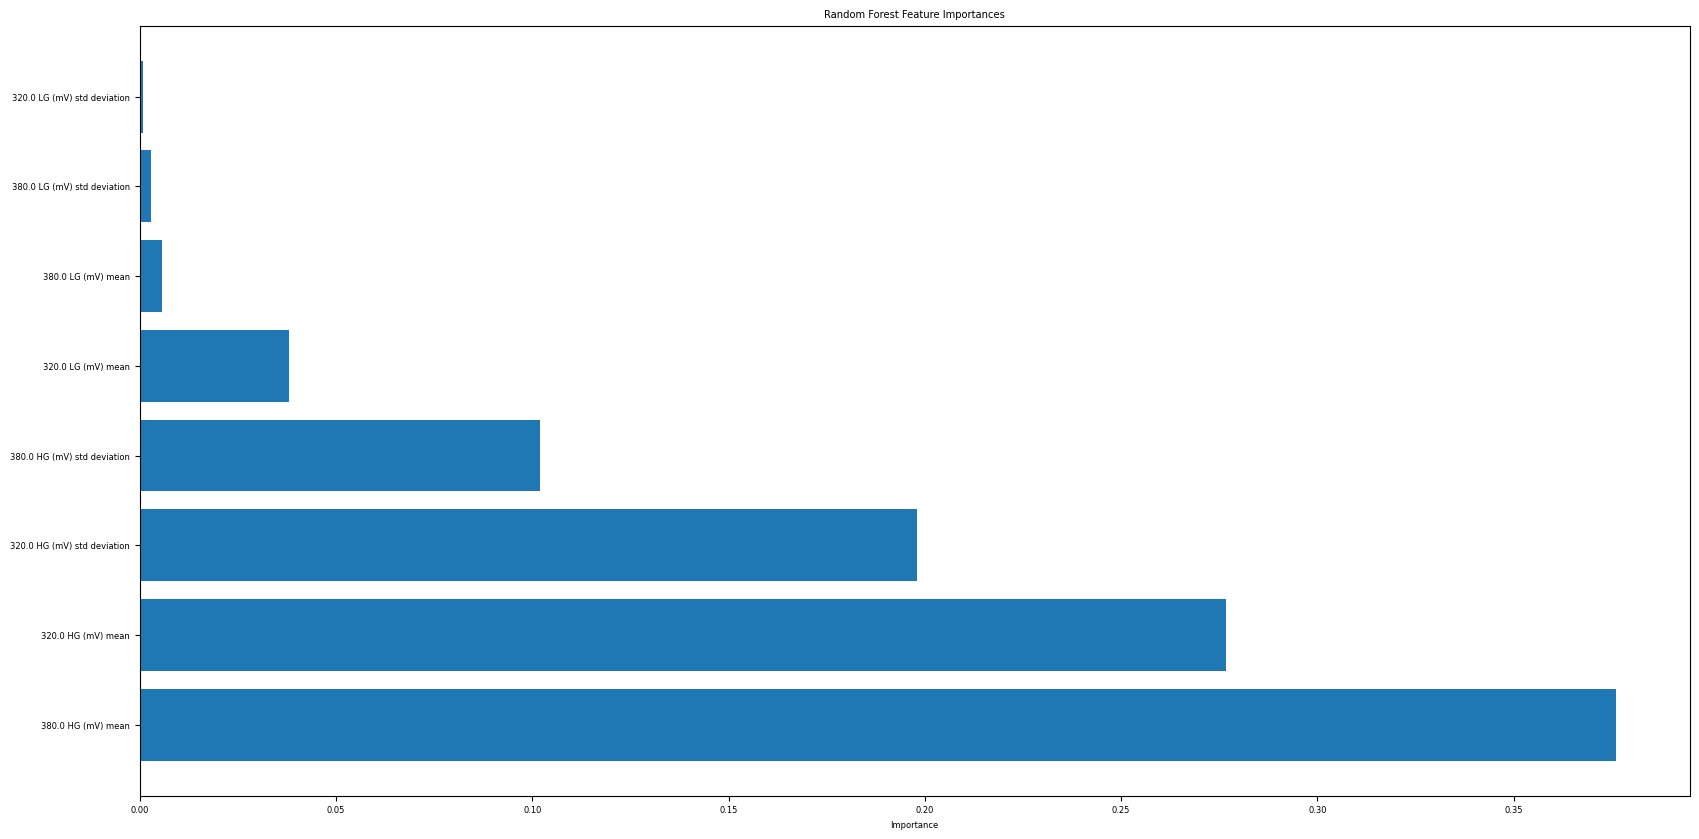

In [329]:
# Train models
rf_model = random_forest_model(X_train, y_train, seed)
nb_model = naive_bayes_model(X_train, y_train)
lr_model = logistic_regression_model(X_train, y_train, seed)

# Predictions
y_pred = []
y_pred.append(rf_model.predict(X_test))
y_pred.append(nb_model.predict(X_test))
y_pred.append(lr_model.predict(X_test))

# Save the model
# joblib.dump(rf_model, 'random_forest_model.pkl')
# joblib.dump(nb_model, 'naive_bayes_model.pkl')
# joblib.dump(lr_model, 'logistic_regression_model.pkl')

# # Create a DataFrame to compare
# df_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(df_comparison.head(10))

# Calculate metrics
for i, y_pred_i in enumerate(y_pred):
    accuracy = accuracy_score(y_test, y_pred_i)
    precision = precision_score(y_test, y_pred_i, average='weighted')
    recall = recall_score(y_test, y_pred_i, average='weighted')
    f1 = f1_score(y_test, y_pred_i, average='weighted')

    print(f"Model {i+1} - Accuracy: {accuracy}")
    print(f"Model {i+1} - Precision: {precision}")
    print(f"Model {i+1} - Recall: {recall}")
    print(f"Model {i+1} - F1: {f1}")

    # Classification report
    print(f"Model {i+1} - Classification Report:\n", classification_report(y_test, y_pred_i), '\n')

    # Predictions made per class with its label encoded value
    print(f"Model {i+1} - Predictions Counter:\n", Counter(y_pred_i), '\n')

# Feature importance (Find 10 most important variables with its name and importance value)
rf_feature_importances = rf_model.feature_importances_
# lr_feature_importances = lr_model.coef_[0]

feature_names = X_train.columns
rf_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances})
# lr_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lr_feature_importances})

rf_feature_importances_df = rf_feature_importances_df.sort_values('Importance', ascending=False)
# lr_feature_importances_df = lr_feature_importances_df.sort_values('Importance', ascending=False)

# Font size
plt.rcParams.update({'font.size': 6})

n = 20
print("Random Forest Feature Importances:\n", rf_feature_importances_df.head(n))


plt.figure(figsize=(20, 10))
plt.barh(rf_feature_importances_df['Feature'][:n], rf_feature_importances_df['Importance'][:n])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()


# print("Logistic Regression Feature Importances:\n", lr_feature_importances_df.head(204))
# plt.figure(figsize=(20, 10))
# plt.barh(lr_feature_importances_df['Feature'][:n], lr_feature_importances_df['Importance'][:n])
# plt.xlabel('Importance')
# plt.title('Logistic Regression Feature Importances')
# plt.show()

# # sum all the importances of LR
# print(lr_feature_importances_df['Importance'].sum())


### Permutation Importance

C:\Users\Danim\AppData\Local\Temp\ipykernel_39176\1096368883.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])


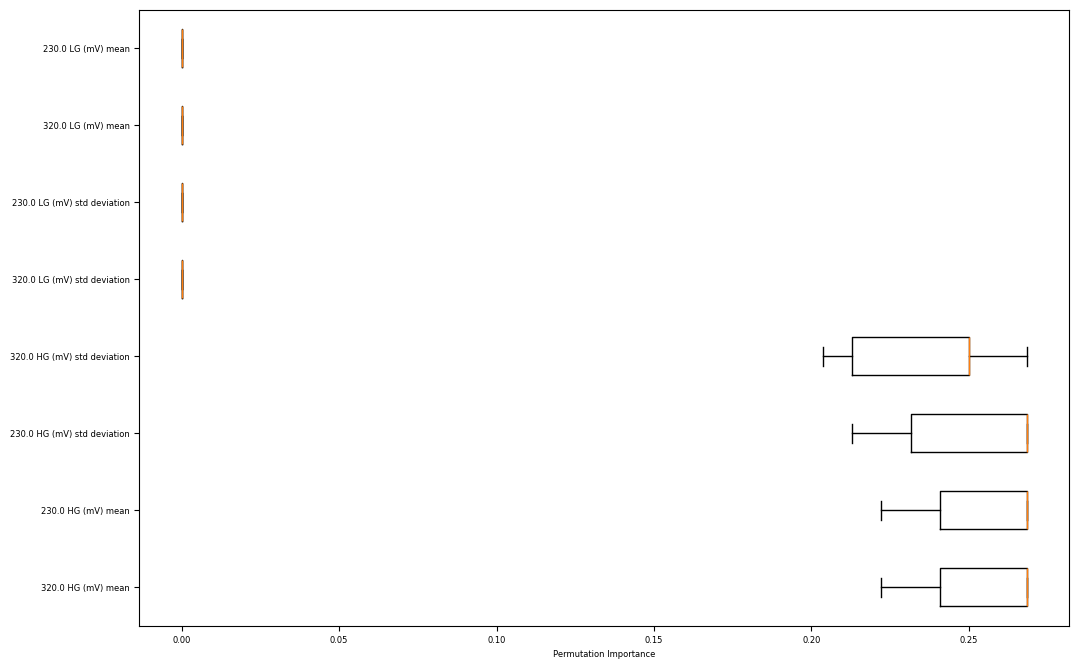

Permutation Importance:

320.0 HG (mV) mean: 0.2537
230.0 HG (mV) mean: 0.2537
230.0 HG (mV) std deviation: 0.2500
320.0 HG (mV) std deviation: 0.2370
320.0 LG (mV) std deviation: 0.0000
230.0 LG (mV) std deviation: 0.0000
320.0 LG (mV) mean: 0.0000
230.0 LG (mV) mean: 0.0000


In [290]:
result = permutation_importance(nb_model, X_test, y_test, n_repeats=5, random_state=seed, n_jobs=2)

# Preserve n most important features
n = 20
sorted_idx = result.importances_mean.argsort()[::-1][:n]  # Sort indices in descending order

plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

# Print n most important features from highest to lowest with their values
print("Permutation Importance:\n")
for i in sorted_idx:
    print(f"{X_train.columns[i]}: {result.importances_mean[i]:.4f}")


In [330]:
# Export Random Forest model with graphviz
feature_names = X_train.columns.tolist()  # Replace with your actual feature names

# Export the first tree in the Random Forest
dot_data = export_graphviz(
    rf_model.estimators_[0], 
    out_file=None, 
    filled=True, 
    rounded=True, 
    special_characters=True,
    feature_names=feature_names
)

# Create a graph from the dot data
graph = graphviz.Source(dot_data)

# Render the graph to a file
graph.render('random_forest_model')


'random_forest_model.pdf'

## Confusion Matrix

In [292]:
# # Confusion matrix with matplotlib

def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=9,
                     ha='center', va='center', color='white')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title('Confusion Matrix')
    plt.show()


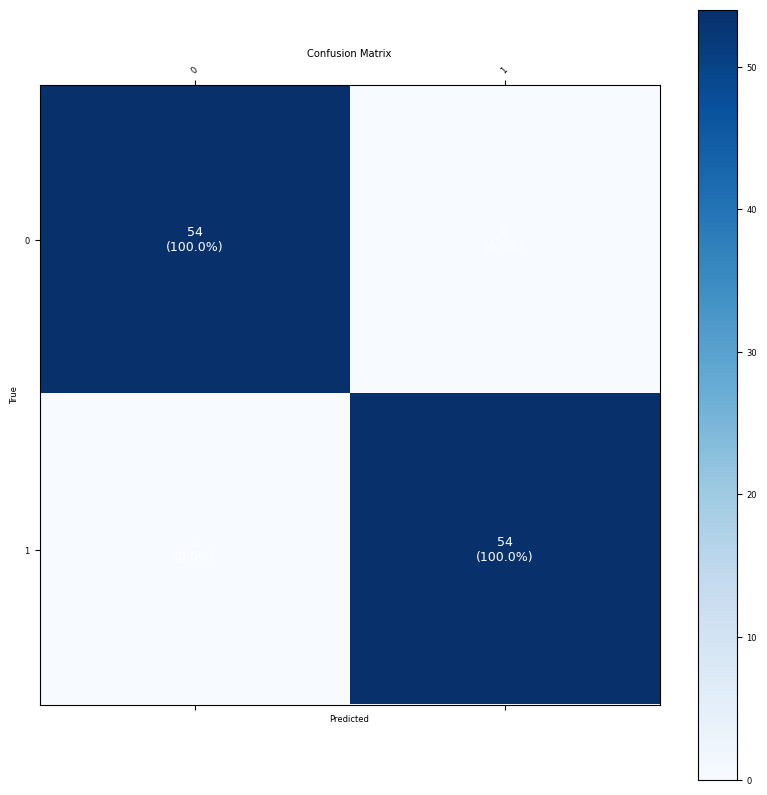

In [313]:
plot_confusion_matrix(y_test, y_pred[0], np.unique(y_test))

## Load and preprocess Other Test Data (Experiment 2)
Prepare new sample for testing (Testing other samples, out of initial dataset)

In [316]:
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'

df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

# labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']
# freqs = [320,380]

# Add .0 on every Frequency column value to match the format of the training data
df_new_sample['Frequency (GHz)'] = df_new_sample['Frequency (GHz)'].astype(str) + '.0'
print('X_new_sample:', df_new_sample)

# Time window
time_window_s = 0.1
sample_time_s = 12
data_percentage = (100/sample_time_s)*time_window_s
print(f"Data percentage: {data_percentage}%")

# Introduce Frequency values as input variables
df_new_sample = freq_as_variable(df_new_sample, data_percentage = data_percentage) # 0.22

df_new_sample = df_new_sample.dropna()

X_new_sample, y_new_sample = preprocess_data(df_new_sample, labels, freqs, eliminate_std_dev=False)

# load the label encoder
le = joblib.load('label_encoder.pkl')
y_new_sample = le.transform(y_new_sample)

print(y_new_sample)


# # Number of samples per frequency
# bx = df_new_sample.groupby(['Frequency (GHz']).size().plot.bar(figsize=(16, 4))
# bx.set_xlabel('Frequency (GHz)')
# bx.set_ylabel('Num of samples')
# plt.tight_layout()
# plt.show()


# Number of samples
num_samples = len(y_new_sample)

X_new_sample.head()


X_new_sample:       Frequency (GHz)   LG (mV)    HG (mV) Sample
0               100.0  0.000000  15.138566     H1
1               100.0 -1.098767  38.701013     H1
2               100.0  0.366256  37.358075     H1
3               100.0  0.488341  28.079599     H1
4               100.0  1.220852  46.880722     H1
...               ...       ...        ...    ...
73553           600.0  1.465023  38.456842     H1
73554           600.0 -1.953363  20.144060     H1
73555           600.0  0.244170  28.201684     H1
73556           600.0  0.610426  18.312782     H1
73557           600.0 -0.244170  30.521303     H1

[73558 rows x 4 columns]
Data percentage: 0.8333333333333335%
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


,100.0 HG (mV) mean,100.0 HG (mV) std deviation,100.0 LG (mV) mean,100.0 LG (mV) std deviation,110.0 HG (mV) mean,110.0 HG (mV) std deviation,110.0 LG (mV) mean,110.0 LG (mV) std deviation,120.0 HG (mV) mean,120.0 HG (mV) std deviation,...,580.0 LG (mV) mean,580.0 LG (mV) std deviation,590.0 HG (mV) mean,590.0 HG (mV) std deviation,590.0 LG (mV) mean,590.0 LG (mV) std deviation,600.0 HG (mV) mean,600.0 HG (mV) std deviation,600.0 LG (mV) mean,600.0 LG (mV) std deviation
0,32.631633,10.726077,0.034882,0.758221,-0.199762,0.712446,57.835096,17.068552,0.332960,0.950528,...,-0.396777,0.945847,46.290643,13.629955,0.172954,0.923131,30.277133,10.447527,-0.110987,0.671923
1,33.433908,13.417054,-0.174407,0.988958,-0.332956,1.005387,61.308975,14.741487,0.066590,0.892741,...,0.142433,0.512264,46.260122,10.509836,0.274692,0.686930,24.683411,8.664579,0.310762,0.731215
2,29.823674,12.371177,0.034882,0.988599,0.055493,0.576153,49.300229,11.567317,-0.210873,0.991972,...,0.518862,1.047795,41.478451,9.050209,0.010174,0.989717,24.539128,12.941608,0.288565,0.507125
3,32.090970,7.839933,0.680189,0.896744,-0.310742,0.570964,59.855051,14.986087,0.221963,0.612419,...,-0.050869,1.078803,42.516176,8.764374,-0.478167,1.064898,30.798770,7.705713,0.421749,0.950955
4,33.852485,10.972446,0.279052,0.609262,-0.011108,0.461522,59.211329,12.948172,-0.388449,0.597636,...,0.111911,0.623512,47.053676,11.293012,0.162780,0.817040,26.215025,10.875331,0.266368,0.988541


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
              precision    recall  f1-score   support

          H1       1.00      1.00      1.00       120

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

Counter({1: 120})


C:\Users\Danim\AppData\Local\Temp\ipykernel_39176\4027755872.py:11: RuntimeWarning: invalid value encountered in scalar divide
  plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',


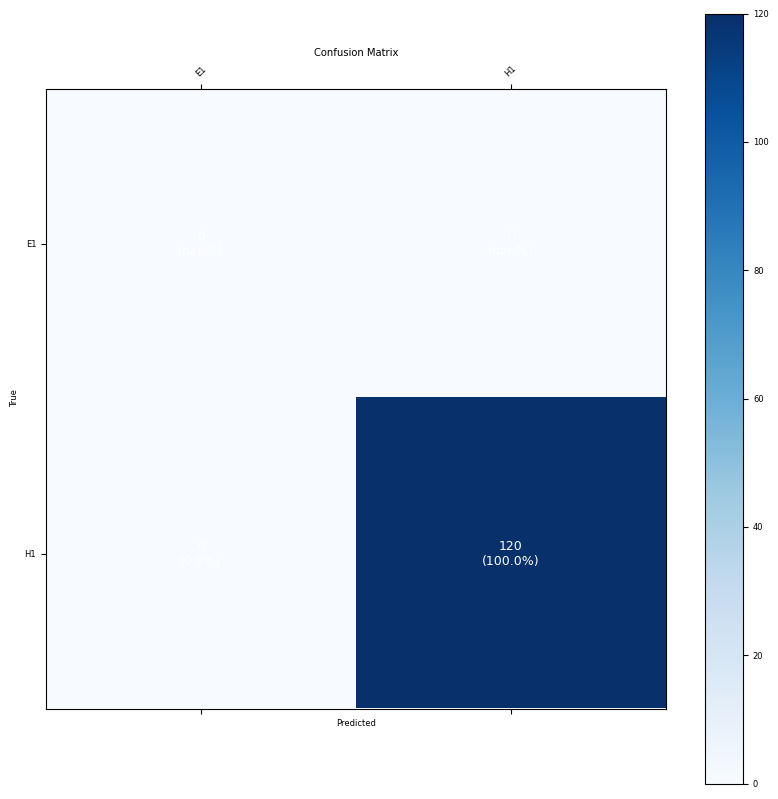

In [317]:
y_pred = rf_model.predict(X_new_sample)
# y_pred = nb_model.predict(X_new_sample)
# y_pred = lr_model.predict(X_new_sample)

# Calculate metrics
accuracy = accuracy_score(y_new_sample, y_pred)
precision = precision_score(y_new_sample, y_pred, average='weighted')
recall = recall_score(y_new_sample, y_pred, average='weighted')
f1 = f1_score(y_new_sample, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Convert the label encoded values back to the original class names
# y_new_sample = le.inverse_transform(y_new_sample)
# y_pred = le.inverse_transform(y_pred)

# Classification report
print(classification_report(le.inverse_transform(y_new_sample), le.inverse_transform(y_pred)), )

# Predictions made per class with its label encoded value
print(Counter(y_pred))

y_new_sample_encoded = le.inverse_transform(y_new_sample)
y_pred_encoded = le.inverse_transform(y_pred)

plot_confusion_matrix(y_new_sample_encoded, y_pred_encoded, labels)

In [183]:
# Load trained model
rf_model = joblib.load('random_forest_model.pkl')

# Predictions
y_pred = rf_model.predict(X_new_sample)



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- 100.0 HG (mV) mean
- 100.0 HG (mV) std deviation
- 100.0 LG (mV) mean
- 100.0 LG (mV) std deviation
- 110.0 HG (mV) mean
- ...


## Feature Importance TBD

## Labels

| Original Label | Encoded Value |
|----------------|---------------|
| A1             | 0             |
| B1             | 1             |
| C1             | 2             |
| D1             | 3             |
| E1             | 4             |
| F1             | 5             |
| G1             | 6             |
| H1             | 7             |
| I1             | 8             |
| J1             | 9             |
| K1             | 10            |
| L1             | 11            |
| M1             | 12            |
| N1             | 13            |
| REF            | 14            |